### 0. cifar10 
1. 기간 : 8월 6일까지 제출 (~ 23:59) 
  - 결과 공개는 8월 8일
2. 허용 범위
  - convolution
  - dropout 
  - 모든 전처리 방법 ok 
  - 모든 규제 방법 (L1, L2 등) 허용 
  - 모든 activation 허용
  - 모든 normalization 방법 금지 (batch, layer, weight 등등)
  - 재학습했을 때 결과가 동일해야 함
  - 미니 배치 사용 (배치 사이즈 상관없음) 
  - 파이토치만 쓸 것 
  - 앙상블 허용 
3. 기준 
  - 정확도
  - 모델 파라미터 수  
  - 학습 횟수 (배치 사이즈 x 스텝 x 주기) 
4. 포상 
  - 개인 : 2만원 상당의 무언가
  - 팀 : 간식 (3만원?)



In [1]:
import matplotlib.pyplot as plt 
import tensorflow as tf
import numpy as np 

### 1. 데이터셋 준비하기

In [2]:
(x_train_all, y_train_all), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
print(x_train_all.shape, y_train_all.shape)

170508288/170498071 [==============================] - 2s 0us/step
(50000, 32, 32, 3) (50000, 1)


In [3]:
class_names = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]

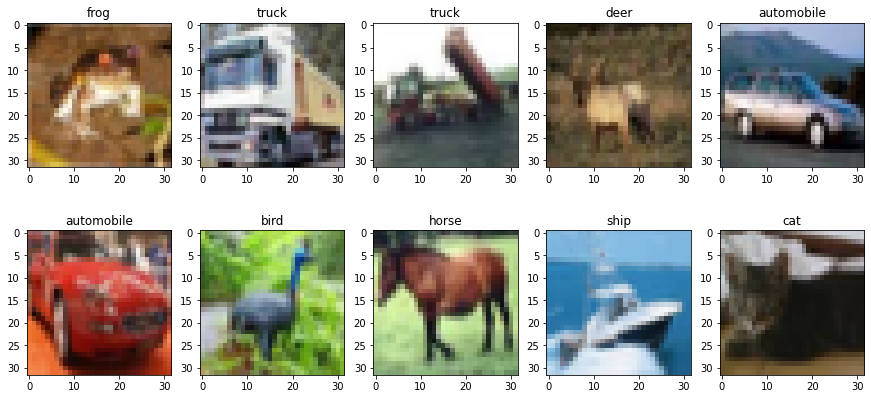

In [4]:
fig = plt.figure(figsize=(15, 7))

for i in range(10):
    plottable_image = x_train_all[i]
    ax = fig.add_subplot(2, 5, i+1)
    ax.title.set_text(class_names[y_train_all[i][0]])
    ax.imshow(plottable_image)

In [5]:
from sklearn.model_selection import train_test_split 
x_train, x_valid, y_train, y_valid = train_test_split(x_train_all, y_train_all, stratify=y_train_all, test_size=0.2, random_state=42)

In [6]:
print("학습 데이터셋 클래스별 샘플 수 : ", np.bincount(y_train.reshape(-1)))
print("평가 데이터셋 클래스별 샘플 수 : ", np.bincount(y_valid.reshape(-1)))

학습 데이터셋 클래스별 샘플 수 :  [4000 4000 4000 4000 4000 4000 4000 4000 4000 4000]
평가 데이터셋 클래스별 샘플 수 :  [1000 1000 1000 1000 1000 1000 1000 1000 1000 1000]


In [7]:
x_test_org = x_test
x_train = x_train / 255 
x_valid = x_valid / 255
x_test = x_test / 255

In [8]:
x_train.shape

(40000, 32, 32, 3)

In [9]:

x_train_reshape = x_train.transpose(0,3,1,2)
x_valid_reshape = x_valid.transpose(0,3,1,2)
x_test_reshape = x_test.transpose(0,3,1,2)

In [10]:
x_train_reshape.shape


(40000, 3, 32, 32)

In [11]:
y_train_encoded = tf.keras.utils.to_categorical(y_train)
y_valid_encoded = tf.keras.utils.to_categorical(y_valid)

In [12]:
import torch
cuda_ = torch.cuda.is_available()
device = torch.device("cuda" if cuda_ else "cpu")
print(device)
x_train_torch = torch.FloatTensor(x_train_reshape).to(device)
y_train_torch = torch.FloatTensor(y_train_encoded).to(device)
x_valid_torch = torch.FloatTensor(x_valid_reshape).to(device)
y_valid_torch = torch.FloatTensor(y_valid_encoded).to(device) 
x_test_torch = torch.FloatTensor(x_test_reshape).to(device)
y_test_torch = torch.FloatTensor(y_test).to(device)

cuda


In [13]:
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

In [14]:
class Cifar10_Dataset(Dataset):
    def __init__(self, x, y):
        self.x_data = x
        self.y_data = y
    
    def __getitem__(self, index):
        x = self.x_data[index]
        y = self.y_data[index]
        return x, y

    def collate_fn(self, batch):
        x, y = zip(*batch)
        return x, y

    def __len__(self):
        return len(self.x_data)

In [15]:
dataset = Cifar10_Dataset(x_train_torch, y_train_torch)
dataloader = DataLoader(dataset, batch_size=100, shuffle=True, drop_last=True)

In [16]:
from tqdm import tqdm 
import random 

random_seed = 1004
np.random.seed(random_seed)
torch.manual_seed(random_seed)
random.seed(random_seed)

class MyModel(nn.Module):
  def __init__(self):
    super(MyModel, self).__init__()
    self.net = nn.Sequential(
        nn.Conv2d(in_channels=3, out_channels=10, kernel_size=3, stride=1, padding=1),      
        nn.ReLU(),
        nn.Dropout(0.3),
        nn.Conv2d(in_channels=10, out_channels=1, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=3),
        nn.Dropout(0.3),
    )
    
    self.linear1 = nn.Linear(100, 50)
    self.linear2 = nn.Linear(50, 10)
  
  def forward(self, x):
    output = self.net(x)
    output = output.view(-1, 1, 100)
    output = self.linear1(output)
    output = self.linear2(output)
    return output

In [17]:
import torch.nn.functional as func

random_seed = 1004
np.random.seed(random_seed)
torch.manual_seed(random_seed)
random.seed(random_seed)
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, kernel_size=5)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        self.fc1 = nn.Linear(16*5*5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = func.relu(self.conv1(x))
        x = func.max_pool2d(x, 2)
        x = func.relu(self.conv2(x))
        x = func.max_pool2d(x, 2)
        x = x.view(x.size(0), -1)
        x = func.relu(self.fc1(x))
        x = func.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [18]:
random_seed = 1004
np.random.seed(random_seed)
torch.manual_seed(random_seed)
random.seed(random_seed)
cfg = {
    'VGG11': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'VGG13': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'VGG16': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
    'VGG19': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M'],
}


class VGG(nn.Module):
    def __init__(self, vgg_name):
        super(VGG, self).__init__()
        self.features = self._make_layers(cfg[vgg_name])
        self.classifier = nn.Linear(512, 10)

    def forward(self, x):
        out = self.features(x)
        out = out.view(out.size(0), -1)
        out = self.classifier(out)
        return out

    def _make_layers(self, cfg):
        layers = []
        in_channels = 3
        for x in cfg:
            if x == 'M':
                layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
            else:
                layers += [nn.Conv2d(in_channels, x, kernel_size=3, padding=1),
                           nn.ReLU(inplace=True)]
                in_channels = x
        layers += [nn.AvgPool2d(kernel_size=1, stride=1)]
        return nn.Sequential(*layers)


def VGG11():
    return VGG('VGG11')


def VGG13():
    return VGG('VGG13')


def VGG16():
    return VGG('VGG16')


def VGG19():
    return VGG('VGG19')

In [19]:
# model = MyModel().to(device)
# model = LeNet().to(device)
model = VGG19().to(device)
optim = torch.optim.Adam(model.parameters(), lr=1e-4)
# optim = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
criterion = nn.CrossEntropyLoss().to(device)

global_step = 0 
for epoch in range(30):
    t = tqdm(dataloader, ncols=100)
    for i, batch in enumerate(t):
        x_batch = batch[0]
        y_batch = batch[1]
        model.zero_grad()
        output = model(x_batch)
        loss = criterion(output, y_batch)
        loss.backward()
        optim.step()
        # optim.zero_grad()

        global_step += 1
        t.set_description("epoch: {} | global_step: {:8d} | loss: {:.4f}".format(epoch + 1, global_step, loss))
    with torch.no_grad():
        model.eval()
        predicts = model(x_valid_torch)
        predicts = torch.argmax(predicts, 1)

        correct = 0 
        for i in range(len(predicts)):
          if predicts[i].item() == y_valid[i]:
              correct += 1
        acc = correct / len(predicts)
        print("epoch: {} | global_step: {} | valid acc: {:%}".format(epoch + 1, global_step, acc))
        model.train()

epoch: 1 | global_step:      400 | loss: 2.3031: 100%|████████████| 400/400 [00:30<00:00, 13.15it/s]


epoch: 1 | global_step: 400 | valid acc: 10.000000%


epoch: 2 | global_step:      800 | loss: 1.8513: 100%|████████████| 400/400 [00:24<00:00, 16.15it/s]


epoch: 2 | global_step: 800 | valid acc: 23.360000%


epoch: 3 | global_step:     1200 | loss: 1.7916: 100%|████████████| 400/400 [00:24<00:00, 16.62it/s]


epoch: 3 | global_step: 1200 | valid acc: 33.810000%


epoch: 4 | global_step:     1600 | loss: 1.5264: 100%|████████████| 400/400 [00:24<00:00, 16.45it/s]


epoch: 4 | global_step: 1600 | valid acc: 41.300000%


epoch: 5 | global_step:     2000 | loss: 1.3711: 100%|████████████| 400/400 [00:24<00:00, 16.30it/s]


epoch: 5 | global_step: 2000 | valid acc: 49.540000%


epoch: 6 | global_step:     2400 | loss: 1.3369: 100%|████████████| 400/400 [00:24<00:00, 16.33it/s]


epoch: 6 | global_step: 2400 | valid acc: 53.890000%


epoch: 7 | global_step:     2800 | loss: 1.1173: 100%|████████████| 400/400 [00:24<00:00, 16.25it/s]


epoch: 7 | global_step: 2800 | valid acc: 58.810000%


epoch: 8 | global_step:     3200 | loss: 1.0168: 100%|████████████| 400/400 [00:24<00:00, 16.10it/s]


epoch: 8 | global_step: 3200 | valid acc: 61.820000%


epoch: 9 | global_step:     3600 | loss: 0.9366: 100%|████████████| 400/400 [00:25<00:00, 15.93it/s]


epoch: 9 | global_step: 3600 | valid acc: 64.470000%


epoch: 10 | global_step:     4000 | loss: 0.7388: 100%|███████████| 400/400 [00:24<00:00, 16.09it/s]


epoch: 10 | global_step: 4000 | valid acc: 64.730000%


epoch: 11 | global_step:     4400 | loss: 0.7887: 100%|███████████| 400/400 [00:24<00:00, 16.04it/s]


epoch: 11 | global_step: 4400 | valid acc: 67.050000%


epoch: 12 | global_step:     4800 | loss: 0.6686: 100%|███████████| 400/400 [00:25<00:00, 15.89it/s]


epoch: 12 | global_step: 4800 | valid acc: 70.400000%


epoch: 13 | global_step:     5200 | loss: 0.7482: 100%|███████████| 400/400 [00:25<00:00, 15.86it/s]


epoch: 13 | global_step: 5200 | valid acc: 72.660000%


epoch: 14 | global_step:     5600 | loss: 0.6734: 100%|███████████| 400/400 [00:25<00:00, 15.57it/s]


epoch: 14 | global_step: 5600 | valid acc: 71.260000%


epoch: 15 | global_step:     6000 | loss: 0.4916: 100%|███████████| 400/400 [00:25<00:00, 15.77it/s]


epoch: 15 | global_step: 6000 | valid acc: 70.530000%


epoch: 16 | global_step:     6400 | loss: 0.6755: 100%|███████████| 400/400 [00:25<00:00, 15.93it/s]


epoch: 16 | global_step: 6400 | valid acc: 73.960000%


epoch: 17 | global_step:     6800 | loss: 0.6358: 100%|███████████| 400/400 [00:25<00:00, 15.77it/s]


epoch: 17 | global_step: 6800 | valid acc: 72.940000%


epoch: 18 | global_step:     7200 | loss: 0.5318: 100%|███████████| 400/400 [00:25<00:00, 15.88it/s]


epoch: 18 | global_step: 7200 | valid acc: 74.820000%


epoch: 19 | global_step:     7600 | loss: 0.4374: 100%|███████████| 400/400 [00:25<00:00, 15.62it/s]


epoch: 19 | global_step: 7600 | valid acc: 75.480000%


epoch: 20 | global_step:     8000 | loss: 0.1849: 100%|███████████| 400/400 [00:25<00:00, 15.67it/s]


epoch: 20 | global_step: 8000 | valid acc: 74.950000%


epoch: 21 | global_step:     8400 | loss: 0.3269: 100%|███████████| 400/400 [00:25<00:00, 15.82it/s]


epoch: 21 | global_step: 8400 | valid acc: 74.330000%


epoch: 22 | global_step:     8800 | loss: 0.2513: 100%|███████████| 400/400 [00:25<00:00, 15.88it/s]


epoch: 22 | global_step: 8800 | valid acc: 75.630000%


epoch: 23 | global_step:     9200 | loss: 0.3252: 100%|███████████| 400/400 [00:25<00:00, 15.87it/s]


epoch: 23 | global_step: 9200 | valid acc: 75.440000%


epoch: 24 | global_step:     9600 | loss: 0.1557: 100%|███████████| 400/400 [00:25<00:00, 15.83it/s]


epoch: 24 | global_step: 9600 | valid acc: 75.310000%


epoch: 25 | global_step:    10000 | loss: 0.1061: 100%|███████████| 400/400 [00:25<00:00, 15.73it/s]


epoch: 25 | global_step: 10000 | valid acc: 75.230000%


epoch: 26 | global_step:    10400 | loss: 0.2161: 100%|███████████| 400/400 [00:25<00:00, 15.79it/s]


epoch: 26 | global_step: 10400 | valid acc: 75.720000%


epoch: 27 | global_step:    10800 | loss: 0.1607: 100%|███████████| 400/400 [00:25<00:00, 15.81it/s]


epoch: 27 | global_step: 10800 | valid acc: 75.560000%


epoch: 28 | global_step:    11200 | loss: 0.0928: 100%|███████████| 400/400 [00:25<00:00, 15.84it/s]


epoch: 28 | global_step: 11200 | valid acc: 74.400000%


epoch: 29 | global_step:    11600 | loss: 0.1133: 100%|███████████| 400/400 [00:25<00:00, 15.77it/s]


epoch: 29 | global_step: 11600 | valid acc: 75.120000%


epoch: 30 | global_step:    12000 | loss: 0.1204: 100%|███████████| 400/400 [00:25<00:00, 15.81it/s]


epoch: 30 | global_step: 12000 | valid acc: 75.620000%


In [20]:
with torch.no_grad():
  model.eval()
  predict = model(x_test_torch)
  predict = torch.argmax(predict, 1)

In [21]:
correct = 0 
for i in range(len(predict)):
  if predict[i].item() == y_test[i]:
    correct += 1
acc = correct/len(predict)
print("Test accuracy : {:.2%}".format(acc))

Test accuracy : 75.14%


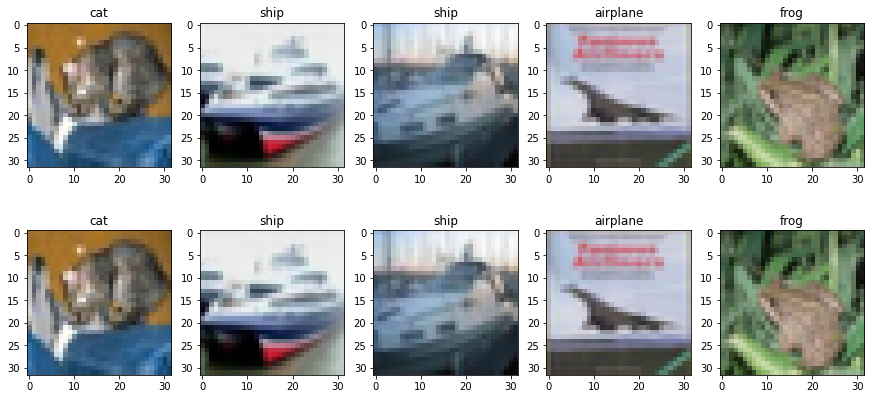

In [22]:
fig = plt.figure(figsize=(15, 7))

for i in range(5):
    plottable_image = x_test_org[i]
    ax = fig.add_subplot(2, 5, i+1)
    ax.title.set_text(class_names[y_test[i][0]])
    ax.imshow(plottable_image)
  
for i in range(5):
    plottable_image = x_test_org[i]
    ax = fig.add_subplot(2, 5, i+6)
    ax.title.set_text(class_names[predict[i].item()])
    ax.imshow(plottable_image)

plt.show()